### Pretrained Convnets
A pretrained network is a saved network that was previous trained on a large dataset, typically on a large-scale image-classification task. If it's big enough and general enough, then the spatial hierarchy of features learned by the pretrained network can effectively act as a generic model, even though these new problems may involve completely different classes. 

### Feature Extraction
Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are run through a new classifier - which is trained from scratch. 

Convnets for image classification has 2 parts:
1. Convolutional Base: Convolution and Pooling Layers
2. Densely connected classifiers
Feature extraction: Take Convolutional base and then train a new classifier!

The level of generality extracted by convolutional layers depend on the depth of the layer. Earlier layers are more generic than later layers - so you may be better off not using later layers. 



In [1]:
from keras.applications import VGG16
# Weights: Specifies where weight should be inialized to
# Include Top: Refers to including the densely connected classifier on top of the network. Here we don't want
# To use the 1000 classes included in imagenet
# Input_shape: Purely optional, if you don't pass it - it can accept inputs of ANY size
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
bloc

### Fast Feature Extraction
Running convolutional base over the dataset, recording it's output to a numpy array on disk, then using this data as input to a standalone, densely connected classifier.

(Alternative is to extend the model that you have --- later)

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = r'C:\Users\pgbpr\Documents\Verusen\keras\dogs-vs-cats\small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    # Notice the hard coded section is the same as the output of the convolutional base
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

# Extracted featires currently of the shape samples, 4, 4, 512. We'll feed them into a fully connected classifier
# So it's got to be (samples, 8192) - which is just everything flattened

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5), 
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels, epochs=30, batch_size=20, validation_data=(validation_features, validation_labels))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 2s 1ms/step - loss: 0.6109 - acc: 0.6575 - val_loss: 0.4259 - val_acc: 0.8610
Epoch 2/30
2000/2000 [==============================] - 1s 549us/step - loss: 0.4207 - acc: 0.8180 - val_loss: 0.3521 - val_acc: 0.8750
Epoch 3/30
2000/2000 [==============================] - 1s 554us/step - loss: 0.3676 - acc: 0.8475 - val_loss: 0.3145 - val_acc: 0.8860
Epoch 4/30
2000/2000 [==============================] - 1s 552us/step - loss: 0.3195 - acc: 0.8675 - val_loss: 0.2938 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 1s 549us/step - loss: 0.2970 - acc: 0.8790 - val_loss: 0.2811 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 1s 548us/step - loss: 0.2672 - acc: 0.8955 - val_loss: 

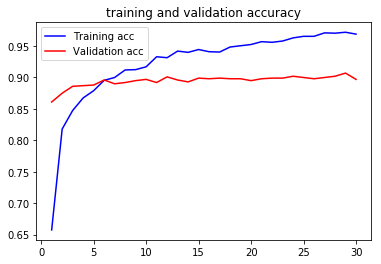

In [10]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('training and validation accuracy')
plt.legend()

### Now we *can* restart the entire network

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


### Freeze layers
Important to freeze the convolutional base (freeze weights). Dense layers are randomly initialized, very large weight updates would be propogated through the network, destroying the weights previously learned. 

In [12]:
print(len(model.trainable_weights))
conv_base.trainable = False
print(len(model.trainable_weights))

30
4


In [13]:
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(150,150),
batch_size=20,
class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(150,150),
batch_size=20,
class_mode='binary')

model.compile(loss='binary_crossentropy', optimizer = optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = model.fit_generator(
train_generator,
steps_per_epoch=100,
epochs=30,
validation_data=validation_generator,
validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 25s 249ms/step - loss: 0.5842 - acc: 0.6930 - val_loss: 0.4413 - val_acc: 0.8410
Epoch 2/30
100/100 [==============================] - 22s 220ms/step - loss: 0.4703 - acc: 0.7895 - val_loss: 0.3578 - val_acc: 0.8690
Epoch 3/30
100/100 [==============================] - 22s 220ms/step - loss: 0.4347 - acc: 0.8040 - val_loss: 0.3305 - val_acc: 0.8670
Epoch 4/30
100/100 [==============================] - 22s 222ms/step - loss: 0.3997 - acc: 0.8225 - val_loss: 0.3099 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 22s 222ms/step - loss: 0.3760 - acc: 0.8445 - val_loss: 0.2846 - val_acc: 0.8950
Epoch 6/30
100/100 [==============================] - 22s 222ms/step - loss: 0.3659 - acc: 0.8360 - val_loss: 0.2768 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 22s 224ms/step - loss: 0.3507 - acc: 0.8445 - val_lo

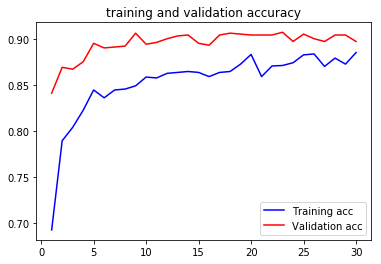

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('training and validation accuracy')
plt.legend()

### Fine-Tuning
Unfreezing later Conv layers. Steps:
1. Add your custom network on top of an already-trained base network
2. Freeze the base network
3. Train the part you added
4. Unfreeze some layers in the base network
5. Jointly train both these layers and the part you added (with a LOW learning rate on the unfrozen layers)

In [16]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-5), metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 263ms/step - loss: 0.2836 - acc: 0.8730 - val_loss: 0.2569 - val_acc: 0.8860
Epoch 2/100
100/100 [==============================] - 24s 245ms/step - loss: 0.2546 - acc: 0.8910 - val_loss: 0.1937 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 25s 246ms/step - loss: 0.2340 - acc: 0.8990 - val_loss: 0.1920 - val_acc: 0.9230
Epoch 4/100
100/100 [==============================] - 25s 246ms/step - loss: 0.2259 - acc: 0.9020 - val_loss: 0.2129 - val_acc: 0.9190
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 0.2115 - acc: 0.9095 - val_loss: 0.3296 - val_acc: 0.8800
Epoch 6/100
100/100 [==============================] - 25s 248ms/step - loss: 0.1906 - acc: 0.9250 - val_loss: 0.2030 - val_acc: 0.9270
Epoch 7/100
100/100 [==============================] - 25s 249ms/step - loss: 0.1877 - acc: 0.9190 - val_loss: 0.2237 - val_acc: 0.9130
Epoch 8/100
100/100 [===========================

Epoch 60/100
100/100 [==============================] - 26s 265ms/step - loss: 0.0530 - acc: 0.9810 - val_loss: 0.1856 - val_acc: 0.9400
Epoch 61/100
100/100 [==============================] - 27s 265ms/step - loss: 0.0251 - acc: 0.9905 - val_loss: 0.2556 - val_acc: 0.9380
Epoch 62/100
100/100 [==============================] - 26s 264ms/step - loss: 0.0402 - acc: 0.9855 - val_loss: 0.2560 - val_acc: 0.9410
Epoch 63/100
100/100 [==============================] - 27s 266ms/step - loss: 0.0337 - acc: 0.9865 - val_loss: 0.2855 - val_acc: 0.9180
Epoch 64/100
100/100 [==============================] - 27s 265ms/step - loss: 0.0294 - acc: 0.9890 - val_loss: 0.3554 - val_acc: 0.9240
Epoch 65/100
100/100 [==============================] - 26s 265ms/step - loss: 0.0227 - acc: 0.9910 - val_loss: 0.2566 - val_acc: 0.9340
Epoch 66/100
100/100 [==============================] - 27s 265ms/step - loss: 0.0302 - acc: 0.9895 - val_loss: 0.2128 - val_acc: 0.9400
Epoch 67/100
100/100 [===================

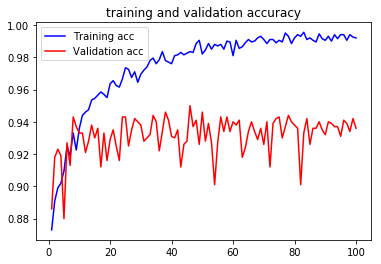

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('training and validation accuracy')
plt.legend()

In [18]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(150,150),
batch_size=20,
class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generatortor, steps=50)
print(f'test acc: {test_acc}')

Found 1000 images belonging to 2 classes.
test acc: 0.9299999916553497


In [19]:
model.save('cats_and_dogs_small_3.h5')